In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(r"D:\Customer Segmentation\retail_sales.csv")
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom

Data Cleaning

In [5]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    missing_values = []
    mean_of_missing = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        missing_values.append(df[i].isna().sum())
        mean_of_missing.append(df[i].isna().sum()/len(df))
    
    return pd.DataFrame({'Column': col, 'dtype': d_type, 'unique sample': uniques, 'n uniques': n_uniques, 'num of missing': missing_values, 'mean of missing': mean_of_missing })


report(df)

Column    dtype                                      unique sample  \
0    InvoiceNo   object           [536365, 536366, 536367, 536368, 536369]   
1    StockCode   object            [85123A, 71053, 84406B, 84029G, 84029E]   
2  Description   object  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...   
3     Quantity    int64                                   [6, 8, 2, 32, 3]   
4  InvoiceDate   object  [2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...   
5    UnitPrice  float64                     [2.55, 3.39, 2.75, 7.65, 4.25]   
6   CustomerID  float64      [17850.0, 13047.0, 12583.0, 13748.0, 15100.0]   
7      Country   object  [United Kingdom, France, Australia, Netherland...   

   n uniques  num of missing  mean of missing  
0      25900               0         0.000000  
1       4070               0         0.000000  
2       4223            1454         0.002683  
3        722               0         0.000000  
4      23260               0         0.000000  
5       1630               0         0.000000  
6       4372          135080         0.249267  
7         38               0         0.000000

In [6]:
df.dropna(inplace=True)

In [7]:
df.describe()

Quantity      UnitPrice     CustomerID
count  406829.000000  406829.000000  406829.000000
mean       12.061303       3.460471   15287.690570
std       248.693370      69.315162    1713.600303
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13953.000000
50%         5.000000       1.950000   15152.000000
75%        12.000000       3.750000   16791.000000
max     80995.000000   38970.000000   18287.000000

Remove Negative Values

In [8]:
df = df[df['Quantity'] > 0]

In [9]:
df.shape

(397924, 8)

EDA

Top Products by Quantity Sold

In [11]:
TopProducts= df.pivot_table(
    index=['StockCode','Description'],
    values='Quantity',
    aggfunc='sum').sort_values(
    by='Quantity', ascending=False)

TopProducts.head(10)

Quantity
StockCode Description                                 
23843     PAPER CRAFT , LITTLE BIRDIE            80995
23166     MEDIUM CERAMIC TOP STORAGE JAR         77916
84077     WORLD WAR 2 GLIDERS ASSTD DESIGNS      54415
85099B    JUMBO BAG RED RETROSPOT                46181
85123A    WHITE HANGING HEART T-LIGHT HOLDER     36725
84879     ASSORTED COLOUR BIRD ORNAMENT          35362
21212     PACK OF 72 RETROSPOT CAKE CASES        33693
22197     POPCORN HOLDER                         30931
23084     RABBIT NIGHT LIGHT                     27202
22492     MINI PAINT SET VINTAGE                 26076

In [12]:
TopProducts.reset_index(inplace=True)

px.bar(TopProducts.head(10), y='Description', x='Quantity',
    orientation='h',
    title='Top 10 Products by Quantity Sold')

The product with the highest quantity sold is "PAPER CRAFT, LITTLE BIRDIE," with approximately 80,000 units.

Let’s check out the number of unique customers:

In [13]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4339

Top Products by Number of Customers

In [14]:
CustomersBoughts = df.pivot_table(index=['StockCode','Description'],
                                values='CustomerID',
                                aggfunc=lambda x: len(x.unique())).sort_values(by='CustomerID', ascending=False)

In [15]:
CustomersBoughts.head(10)


CustomerID
StockCode Description                                   
22423     REGENCY CAKESTAND 3 TIER                   881
85123A    WHITE HANGING HEART T-LIGHT HOLDER         856
47566     PARTY BUNTING                              708
84879     ASSORTED COLOUR BIRD ORNAMENT              678
22720     SET OF 3 CAKE TINS PANTRY DESIGN           640
21212     PACK OF 72 RETROSPOT CAKE CASES            635
85099B    JUMBO BAG RED RETROSPOT                    635
22086     PAPER CHAIN KIT 50'S CHRISTMAS             613
22457     NATURAL SLATE HEART CHALKBOARD             587
22138     BAKING SET 9 PIECE RETROSPOT               581

Top 10 products by number of customers

In [16]:
CustomersBoughts.reset_index(inplace=True)

px.bar(CustomersBoughts.head(10), y='Description', x='CustomerID',
    orientation='h',
    title='Top 10 Products by Number of Customers')

Prepare Data For Modelling

Splitting Data::::
    We will use 90% data of the customers as a training dataset to create word2vec embeddings.

In [17]:
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

Creating Sequence of Purchases for training dataset::::

In [18]:
purchases_train = []

for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3905/3905 [00:01<00:00, 1954.11it/s]


In [19]:
purchases_val = []

for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 434/434 [00:00<00:00, 2451.86it/s]


Building a Recommendation System

Building word2vec Embeddings for products

In [20]:
pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.0 MB 2.8 MB/s eta 0:00:09
    --------------------------------------- 0.4/24.0 MB 3.9 MB/s eta 0:00:07
    --------------------------------------- 0.6/24.0 MB 4.1 MB/s eta 0:00:06
   - -------------------------------------- 0.8/24.0 MB 4.2 MB/s eta 0:00:06
   - -------------------------------------- 1.0/24.0 MB 4.1 MB/s eta 0:00:06
   -- ------------------------------------- 1.3/24.0 MB 4.4 MB/s eta 0:00:06
   -- ------------------------------------- 1.5/24.0 MB 4.7 MB/s eta 0:00:05
   -- ------------------------------------- 1.7/24.0 MB 4.8 MB/s eta 0:00:05
   --- ------------------------------------ 1.9/24.0 MB 4.6 MB/s eta 0:00:05
   --- ------------------------------------ 2.1/24.0 MB 4.5 MB/s eta 0:00:05
   --- ------------------------------------ 2.3/24.0 MB 4.6 MB/s eta 0:00:05
   ---- ----------------------------------- 2.5/24.0 MB 4.5 MB/s eta 0:00:05
   ---


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from gensim.models import Word2Vec

The parameters we will use:

- window = 15: Defines the maximum distance between the current and predicted word within a sentence.

- sg = 1: Means the model will use the Skip-gram approach
- hs = 0: Indicates that hierarchical softmax is not used because there arn't large vocabularies.
- negative=10: Sets the number of negative samples to 10.
- alpha=0.03: Set learning rate for the process to 0.03.
- min_alpha=0.0007: Sets the minimum learning rate to 0.0007.

In [22]:
model = Word2Vec(window = 15, sg = 1, hs = 0,
                 negative = 10, 
                 alpha=0.03, min_alpha=0.0007,
                 seed = 121)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3525897, 3561890)

In [23]:
print(model)

Word2Vec<vocab=3146, vector_size=100, alpha=0.03>


The model has a vocabulary of 3,159 unique words and their vectors of size 100 each.



Extracting the vectors of all the words

In [24]:
X = model.wv[model.wv.index_to_key]

X.shape

(3146, 100)

Visualizing the model

We have 100-dimensional embeddings. We can't even imagine 4 dimensions imagine 100. We are going to reduce the dimensions from 100 to 2 by using the UMAP algorithm.

In [25]:
!pip install umap-learn


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ---------------------------------------- 88.8/88.8 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 2.9 MB/s eta 0:00:00


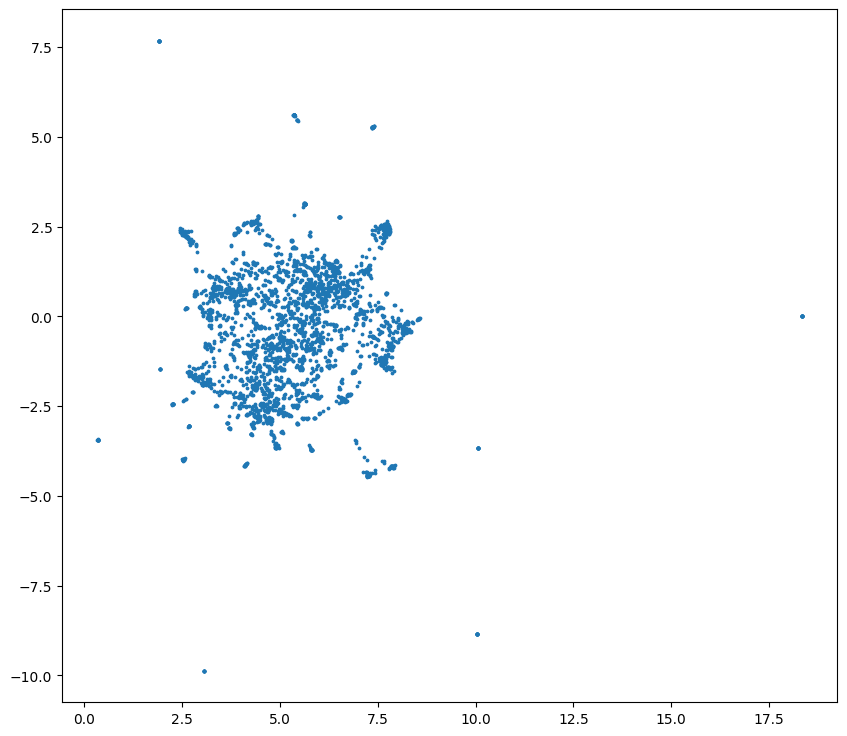

In [26]:
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');

Every dot in this plot is a product. There are several tiny clusters representing similar products.

Recommending Products system Usage

Now, our next step is to suggest similar products for a certain product or a product’s vector.

Let's create a product-ID and product-description dictionary to easily map a product’s description to its ID and vice versa.

In [28]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [29]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

Create a function to return top 5 similar products by default:

In [30]:
def similar_products(v, n = 5):
    
    # extract most similar products
    ms = model.wv.most_similar([v], topn= n+1)[1:]
    
    # extract name and similarity score
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [31]:
products_dict['22112']

['CHOCOLATE HOT WATER BOTTLE']

In [32]:
similar_products(model.wv['22112'])

[('HOT WATER BOTTLE I AM SO POORLY', 0.8668386936187744),
 ('HOT WATER BOTTLE TEA AND SYMPATHY', 0.8468259572982788),
 ('RETROSPOT HEART HOT WATER BOTTLE', 0.7833042740821838),
 ('HOT WATER BOTTLE KEEP CALM', 0.760246217250824),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.757988452911377)]

The results are pretty relevant and match well with the input product.

BUT 

what we need is to recommend products based on the multiple purchases that made in the past. Let's see.

One simple solution is to take the average of all the vectors of the products the user has bought so far and use this vector to find similar products.

In [33]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

Using Validation list of purchase sequences.

In [34]:
len(purchases_val[0]), len(purchases_val[1])

(242, 123)

The length of the first list of products purchased by a user is 247 and the secound is 696. We will pass this products’ sequence of the validation set to the function aggregate_vectors to return array of 100 dimensions

In [35]:
aggregate_vectors(purchases_val[0]).shape, aggregate_vectors(purchases_val[1]).shape

((100,), (100,))

Now we can use this result to get the most similar products:

In [37]:
similar_products(aggregate_vectors(purchases_val[11]))

[('RIBBON REEL CHRISTMAS SOCK BAUBLE', 0.7117326259613037),
 ('RIBBON REEL SNOWY VILLAGE', 0.6936593651771545),
 ('RIBBON REEL SOCKS AND MITTENS', 0.6842150092124939),
 ('RIBBON REEL CHRISTMAS PRESENT ', 0.6820096373558044),
 ('RIBBON REEL MAKING SNOWMEN ', 0.6784197092056274)]

WOOOW!! IT'S COOLL

The model recommended very relative products based the user's past boughts. We can easily get product suggestions based on the last few purchases.

In [38]:
similar_products(aggregate_vectors(purchases_val[11][-10:]))

[('ASSORTED COLOUR MINI CASES', 0.681169331073761),
 ('BAKING SET 9 PIECE RETROSPOT ', 0.6694015264511108),
 ('RETROSPOT TEA SET CERAMIC 11 PC ', 0.6445483565330505),
 ('TRADITIONAL KNITTING NANCY', 0.6320570111274719),
 ('6 RIBBONS RUSTIC CHARM', 0.6178888082504272)]

Coool!

The customer seems to be interested in Home Decor recently.